# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this project am going to classify the traffic signs from the [German Traffic Sign Benchmarks](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

I'm using the scikit-learn's framework in order to train the model.

The project is explained in the following sections.

- Data Exploratory Analysis
- Model Implementation
- Pipeline Implementation
- Preprocessing
- Model Improvement
- Testing and Results

---
## Data Exploratory Analysis
The traffic sign images were taken from the German Traffic Sign Benchmarks.

http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip

In [2]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from pipeline import NeuralNetwork, make_adam, Session, build_pipeline

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

## Load Training Data

All training images path are combined into a dataframe.

In [8]:
TRAIN_IMAGES_DIR = 'data/Final_Training/Images'
dfs = []
for trainfile in glob.glob(os.path.join(TRAIN_IMAGES_DIR, '*/GT-*.csv')):
    folder = trainfile.replace('\\','/').split('/')[3]
    df = pd.read_csv(trainfile, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGES_DIR, folder, x))
    dfs.append(df)

In [9]:
traindf = pd.concat(dfs,ignore_index=True)
traindf.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,data/Final_Training/Images\00000\00000_00000.ppm,29,30,5,6,24,25,0
1,data/Final_Training/Images\00000\00000_00001.ppm,30,30,5,5,25,25,0
2,data/Final_Training/Images\00000\00000_00002.ppm,30,30,5,5,25,25,0
3,data/Final_Training/Images\00000\00000_00003.ppm,31,31,5,5,26,26,0
4,data/Final_Training/Images\00000\00000_00004.ppm,30,32,5,6,25,26,0


**Annotation format**
- Filename: Filename of corresponding image
- Width: Width of the image
- Height: Height of the image
- ROI.x1: X-coordinate of top-left corner of traffic sign bounding box
- ROI.y1: Y-coordinate of top-left corner of traffic sign bounding box
- ROI.x2: X-coordinate of bottom-right corner of traffic sign bounding box
- ROI.y2: Y-coordinate of bottom-right corner of traffic sign bounding box
- ClassId: Assigned class label


## Classes
Number of traffic sign classes

In [11]:
N_CLASSES = np.unique(traindf['ClassId']).size

print("Nr of training images: "+str(traindf.shape[0]))
print("Nr of classes        : "+str(N_CLASSES))

Nr of training images: 39209
Nr of classes        : 43


### Plot traffic sign class distribuition


In [12]:
def show_class_distribuition(class_ids,title):
    plt.figure(figsize=(15,5))
    plt.title('Class ID distribuition for {}'.format(title))
    plt.hist(class_ids, bins=N_CLASSES)
    plt.show()

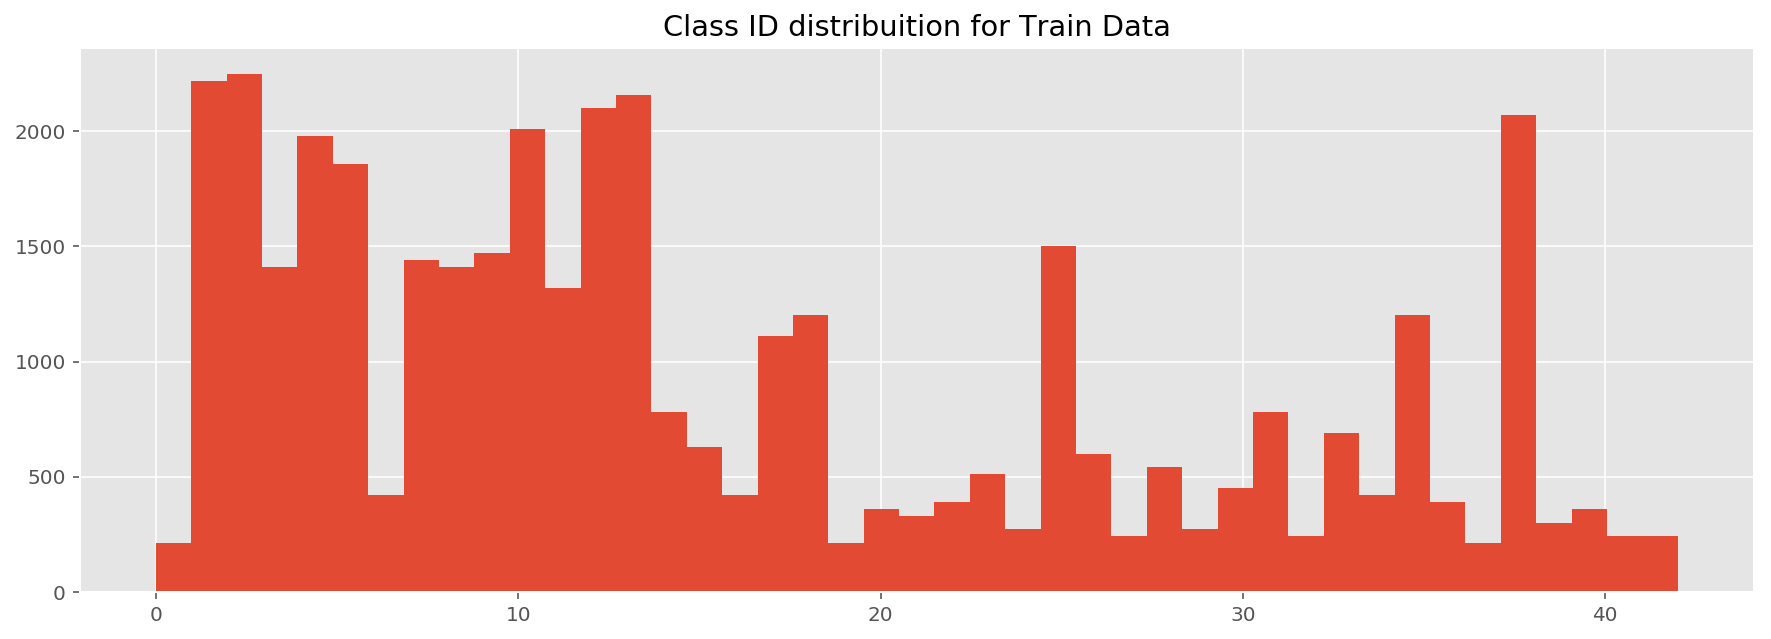

In [13]:
show_class_distribuition(traindf['ClassId'], 'Train Data')

Sign names are stored in sign_names.csv file. We will use it to see distribuition by sign names.

In [16]:
signname_df = pd.read_csv('signnames.csv', index_col='ClassId')
signname_df.head()

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


In [18]:
signname_df['Occurence'] = [sum(traindf['ClassId']==c) for c in range(N_CLASSES)]
signname_df.sort_values('Occurence', ascending=False)

,SignName,Occcurence,Occurence
ClassId,,,
2,Speed limit (50km/h),2250,2250
1,Speed limit (30km/h),2220,2220
13,Yield,2160,2160
12,Priority road,2100,2100
38,Keep right,2070,2070
10,No passing for vehicles over 3.5 metric tons,2010,2010
4,Speed limit (70km/h),1980,1980
5,Speed limit (80km/h),1860,1860
25,Road work,1500,1500


Define constants to use later.

In [20]:
SIGN_NAMES = signname_df.SignName.values
SIGN_NAMES[4]

'Speed limit (70km/h)'

In [29]:
## Sample Images

def load_image(file):
    return plt.imread(file)

def get_samples(image_data, no_samples, class_id=None):
    """
    Random image selection inclusive the class ids
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId'] ==class_id]
    indexes = np.random.choice(image_data.shape[0],size=no_samples, replace=False)
    return image_data.iloc[indexes][['Filename', 'ClassId']].values

def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = load_image(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

Lets show 15 random images

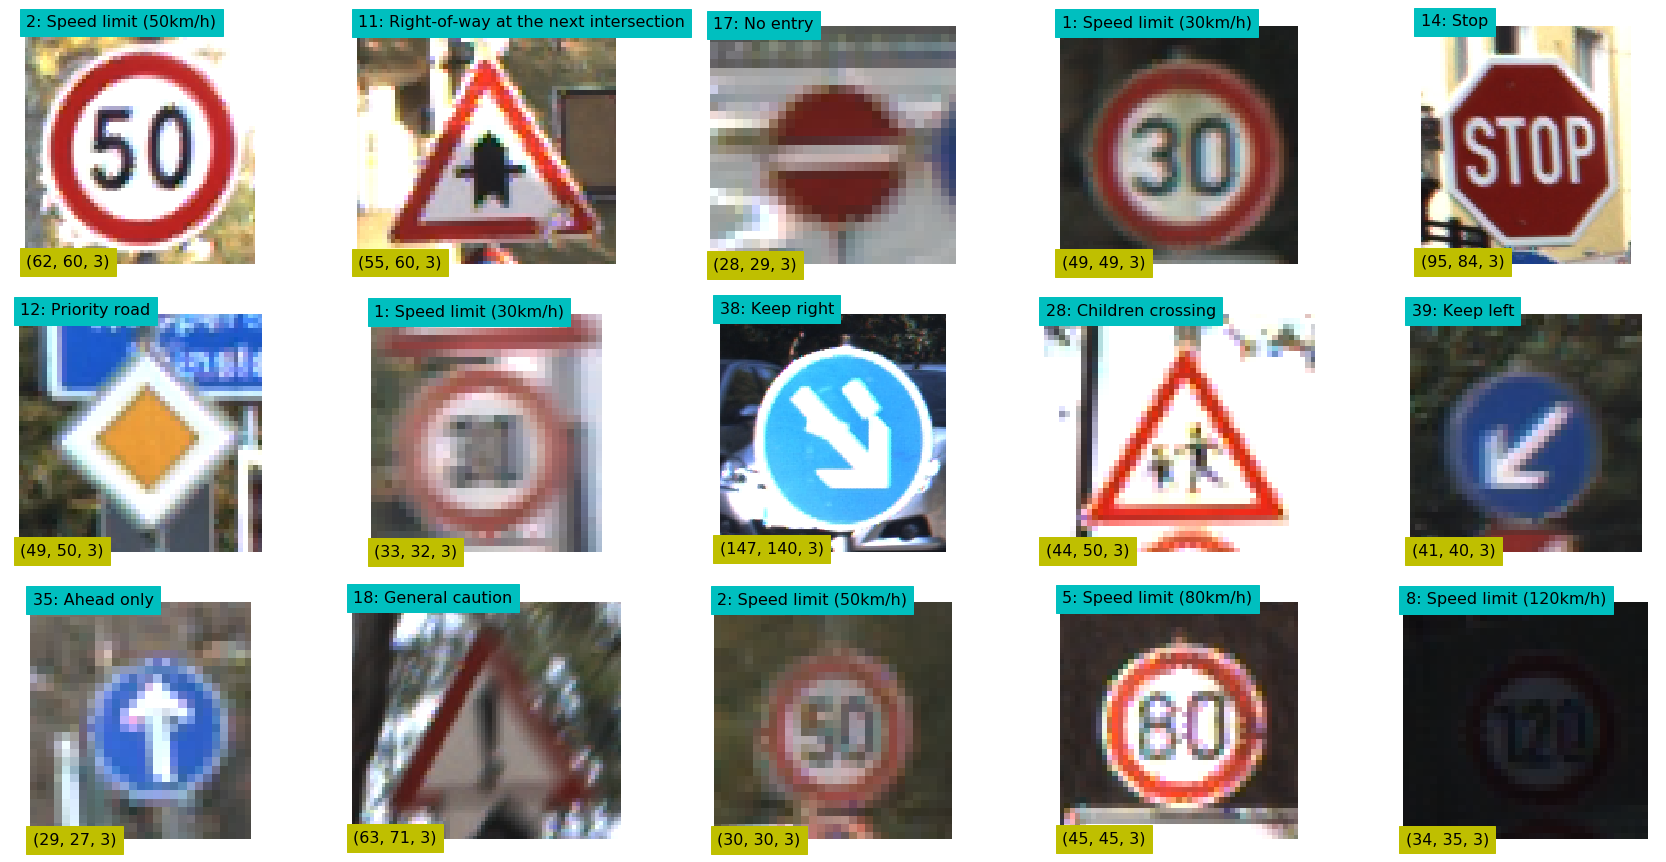

In [30]:
sample_data = get_samples(traindf,15)
show_images(sample_data, sign_names=SIGN_NAMES, show_shape=True)

Speed limit (50km/h)


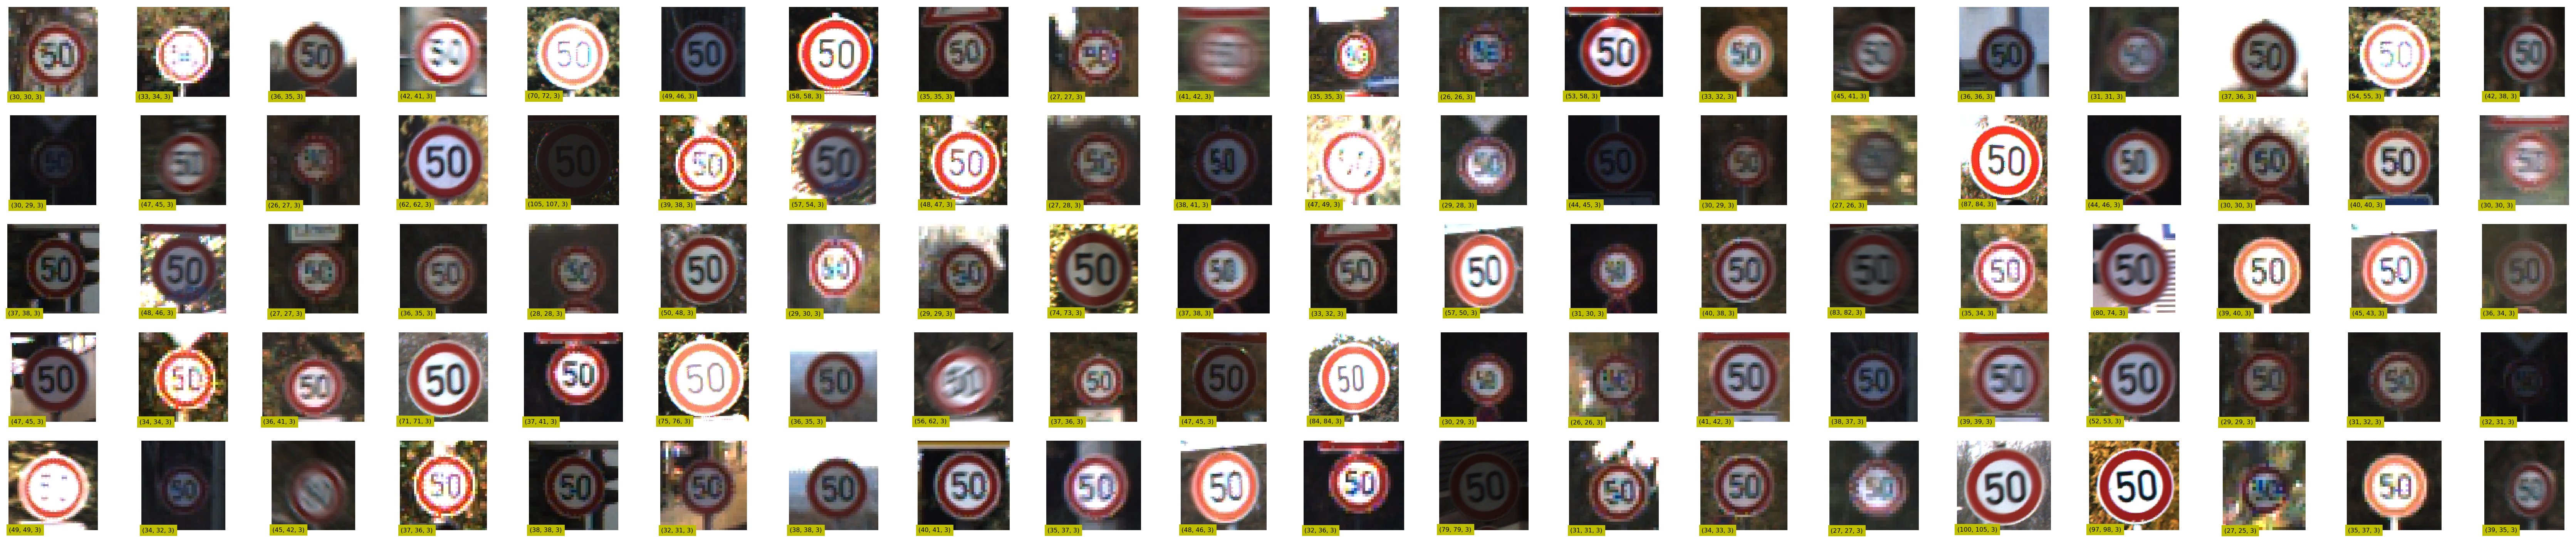

In [31]:
print(SIGN_NAMES[2])
show_images(get_samples(traindf, 100, class_id=2), cols=20, show_shape=True)

Looking at the sample images, we can conclude they:

- have different sizes  
- have random darkness / brightness
- be slightly rotated
- may not be facing straight
- may not be centered
  
Based on that, we start pre-processing them, and then we will augment them.

## Train and Validation Data Set
Train and validation data set are created from training data

In [33]:
X  = traindf['Filename'].values
y = traindf['ClassId'].values

print('X data', len(X))

X data 39209


In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=8000, random_state=0)

print('X_train: ', len(X_train))
print('X_valid: ', len(X_valid))

X_train:  31209
X_valid:  8000


# Model Implementation
## Model Architecture

The model is based on [LeNet](http://yann.lecun.com/exdb/lenet/) by Yann LeCun.  It is a convolutional neural network designed to recognize visual patterns directly from pixel images with minimal preprocessing.  It can handle hand-written characters very well. 

![LeNet](images/lenet.png)

Source: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

- The inputs are 32x32 (Black-White 1 channel) images
- LeNet uses 2x2 sub-sampling (valid padding, max pooling) in convolutional layers (no dropout)
- LeNet uses a sigmoid squashing function - a scaled hyperbolic tangent: $Atanh(Sa)$ where A=1.7159 and S=2/3
- LeNet has one 7x12 bitmap for each class, which is a label.  There are 10 classes (the digits '0' - '9')
- 7x12 = 84 which is why the output is 84
- The output is compared with all the labels (bitmaps) to calculate the error
- The class with the smallest error is an estimated digit value

Our model is adapted from the LeNet as follows.  

- The inputs are 32x32 (RGB - 3 channels) images
- The activation function is ReLU except for the output layer which uses Softmax
- The output has 43 classes

|Layer                       | Shape    |
|----------------------------|:--------:|
|Input                       | 32x32x3  |
|Convolution (valid, 5x5x6)  | 28x28x6  |
|Max Pooling (valid, 2x2)    | 14x14x6  |
|Activation  (ReLU)          | 14x14x6  |
|Convolution (valid, 5x5x16) | 10x10x16 |
|Max Pooling (valid, 2x2)    | 5x5x16   |
|Activation  (ReLU)          | 5x5x16   |
|Flatten                     | 400      |
|Dense                       | 120      |
|Activation  (ReLU)          | 120      |
|Dense                       | 43       |
|Activation  (Softmax)       | 43       |

## Model Implementation

The NeuralNetwork class is defined to provide common operations in neural network using Tensorflow.  See the network.py for details.


The network is based on LeNet

In [40]:
INPUT_SHAPE = (32,32,3)
def make_net(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,6])
           .max_pool().relu()
           .conv([5,5,16])
           .max_pool()
           .relu().flatten().dense(120).relu().dense(N_CLASSES)
           )

## Pipeline implementation

Our pipeline is trained and evaluated by the following function

In [36]:
def train_eval(pipeline, epochs=5, samples_per_epoch=50000, train=(X_train, y_train), test=(X_valid, y_valid)):
    """
    Train and evaluate performance
    Return:
        Array of (epochs, train scores, eval scores)
    """
    X, y = train
    learning_curve = []
    for i in range(epochs):
        indexes = np.random.choice(len(X), size=samples_per_epoch)
        pipeline.fit(X[indexes],y[indexes])
        scores = [pipeline.score(*train), pipeline.score(*test)]
        learning_curve.append([i, *scores])
        print("Epoch: {:>} Train Score: {:.3f} Evaluation Score: {:.3f}".format(i, *scores))
    return np.array(learning_curve).T
        

In [37]:
def resize_image(image, shape=INPUT_SHAPE[:2]):
    return cv2.resize(image, shape)

loader = lambda image_file: resize_image(load_image(image_file))

In [41]:
with Session() as session:
    functions = [loader]
    pipeline = build_pipeline(functions, session, make_net(), make_adam(1.0e-3))
    train_eval(pipeline)

Epoch: 0 Train Score: 0.895 Evaluation Score: 0.876
Epoch: 1 Train Score: 0.941 Evaluation Score: 0.919
Epoch: 2 Train Score: 0.964 Evaluation Score: 0.945
Epoch: 3 Train Score: 0.960 Evaluation Score: 0.943
Epoch: 4 Train Score: 0.977 Evaluation Score: 0.959


**Preliminary conclusion**:

This proves the network is working properly.  The performance is pretty good for the barebone network.

I can see a bit of overfitting.  This is likely because the network is exposed to the same images over and over since I'm using 5 epochs (50K samples per epoch).  At this moment, it is good to see the network is able to overfit and not showing high biases.  The network can handle these images and able to learn from the data.

# Preprocessing
## Image Augmentation

If we increase the number of epochs or samples per epoch, the network will overfit to the training set.  Hence, we should generate more training data using image augmentation.

In [42]:
def rand_brightness(image, ratio):
    """
    Adjust brightness of the image randomly.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = np.float64(hsv[:, :, 2])
    brightness = brightness * (1.0 + np.random.uniform(-ratio, ratio))
    brightness[brightness>255] = 255
    brightness[brightness<0] = 0
    hsv[:, :, 2] = brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def rand_rotation(image, angle):
    """
    Rotate the image randomly
    """
    if angle == 0:
        return image
    angle = np.random.uniform(-angle, angle)
    rows, cols = image.shape[:2]
    size = cols, rows
    center = cols/2, rows/2
    scale = 1.0
    rotation = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rotation, size)


def rand_translation(image, translation):
    """
    Move the image randomly
    """
    if translation == 0:
        return 0
    rows, cols = image.shape[:2]
    size = cols, rows
    x = np.random.uniform(-translation, translation)
    y = np.random.uniform(-translation, translation)
    trans = np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image, trans, size)


def rand_shear(image, shear):
    """
    Distort the image randomly
    """
    if shear == 0:
        return image
    rows, cols = image.shape[:2]
    size = cols, rows
    left, right, top, bottom = shear, cols - shear, shear, rows - shear
    dx = np.random.uniform(-shear, shear)
    dy = np.random.uniform(-shear, shear)
    p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
    p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
    move = cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image, move, size)
    
    
def augment_image(image, brightness, angle, translation, shear):
    image = rand_brightness(image, brightness)
    image = rand_rotation(image, angle)
    image = rand_translation(image, translation)
    image = rand_shear(image, shear)
    return image

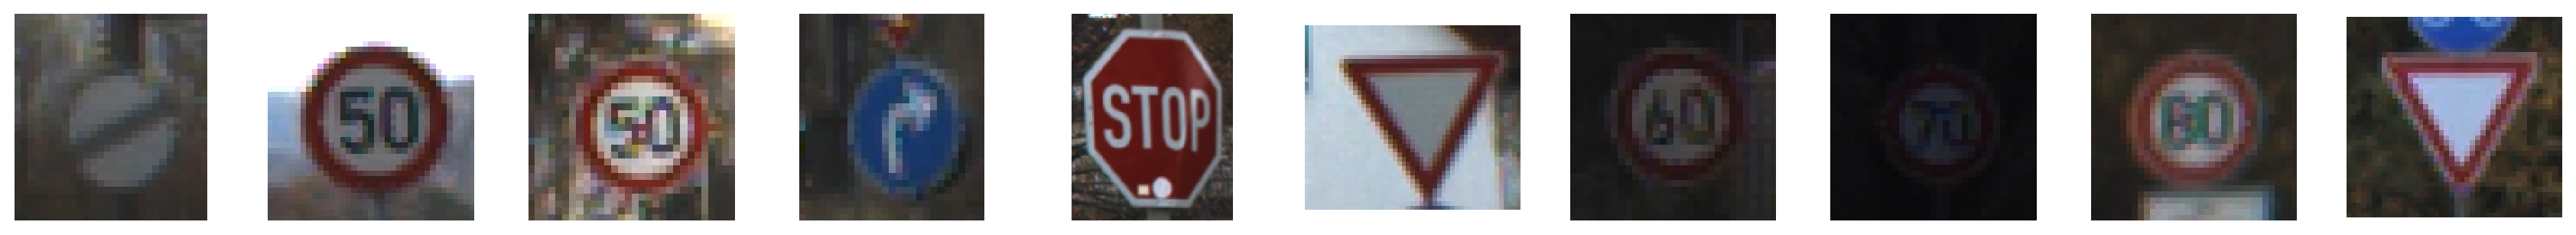

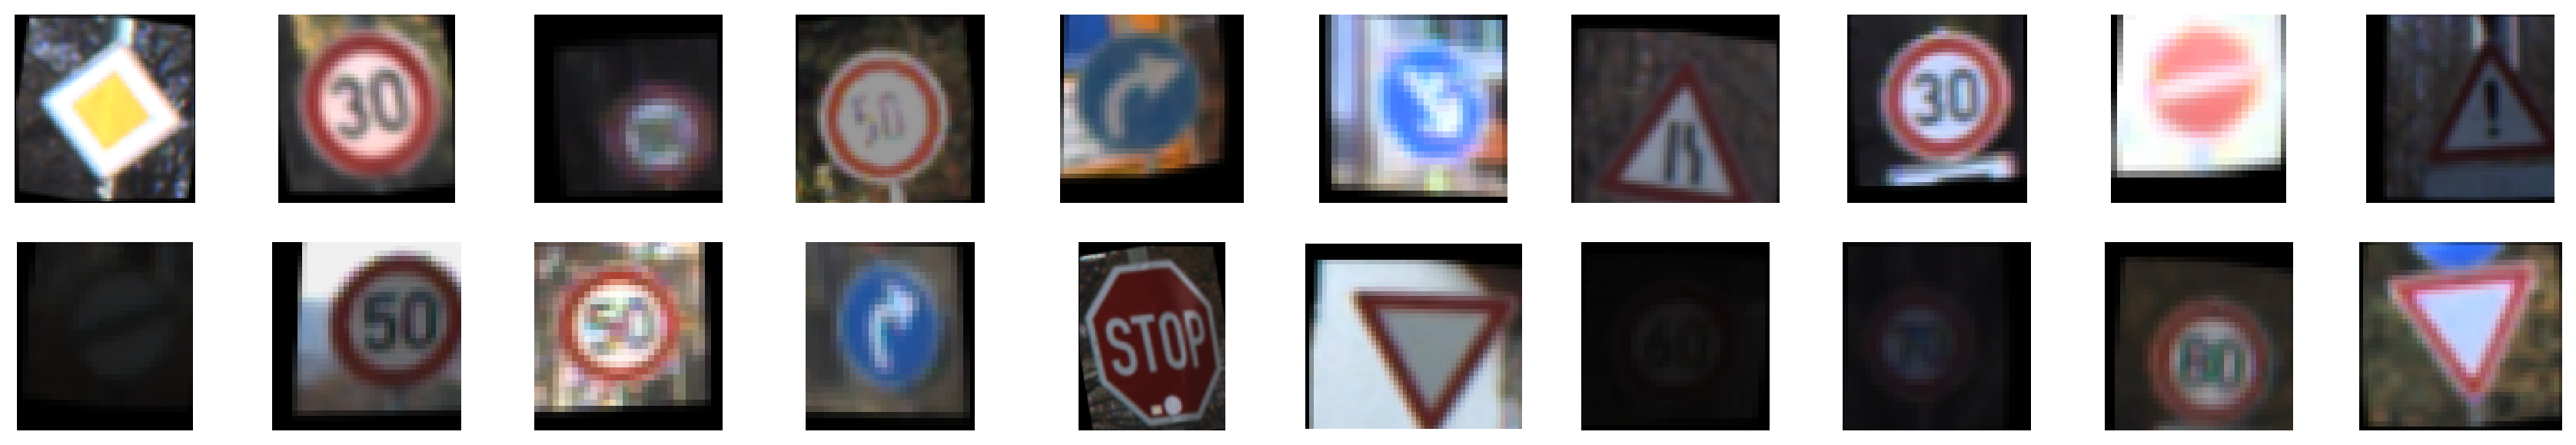

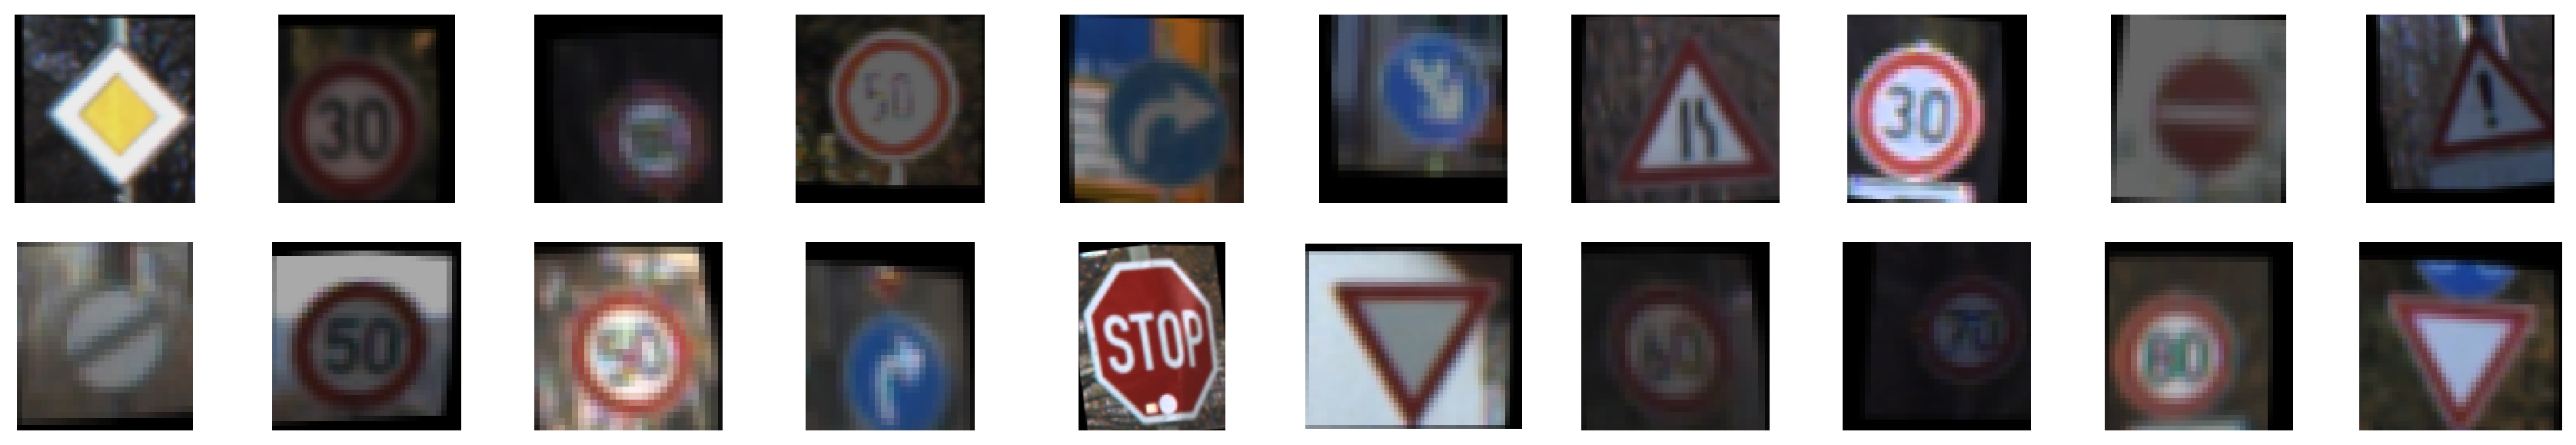

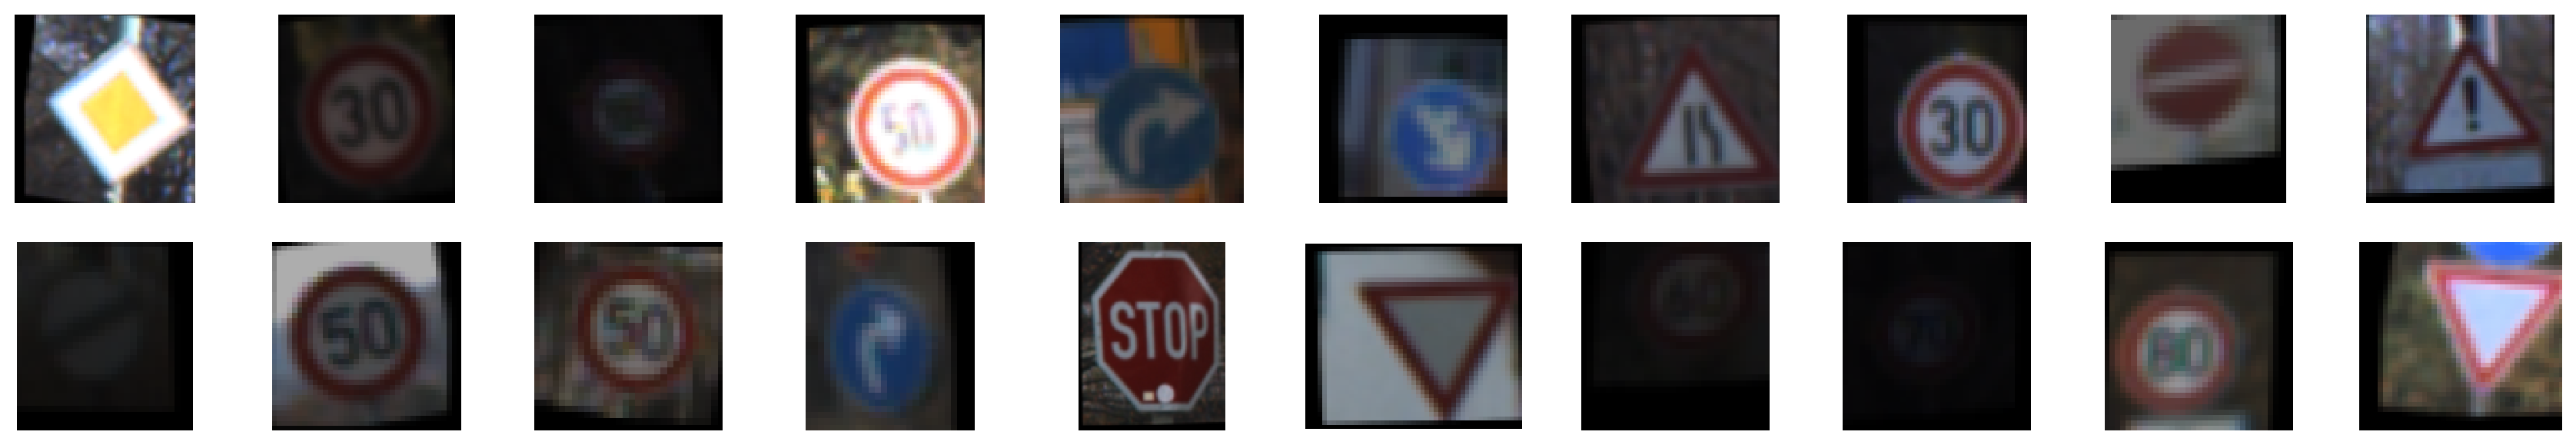

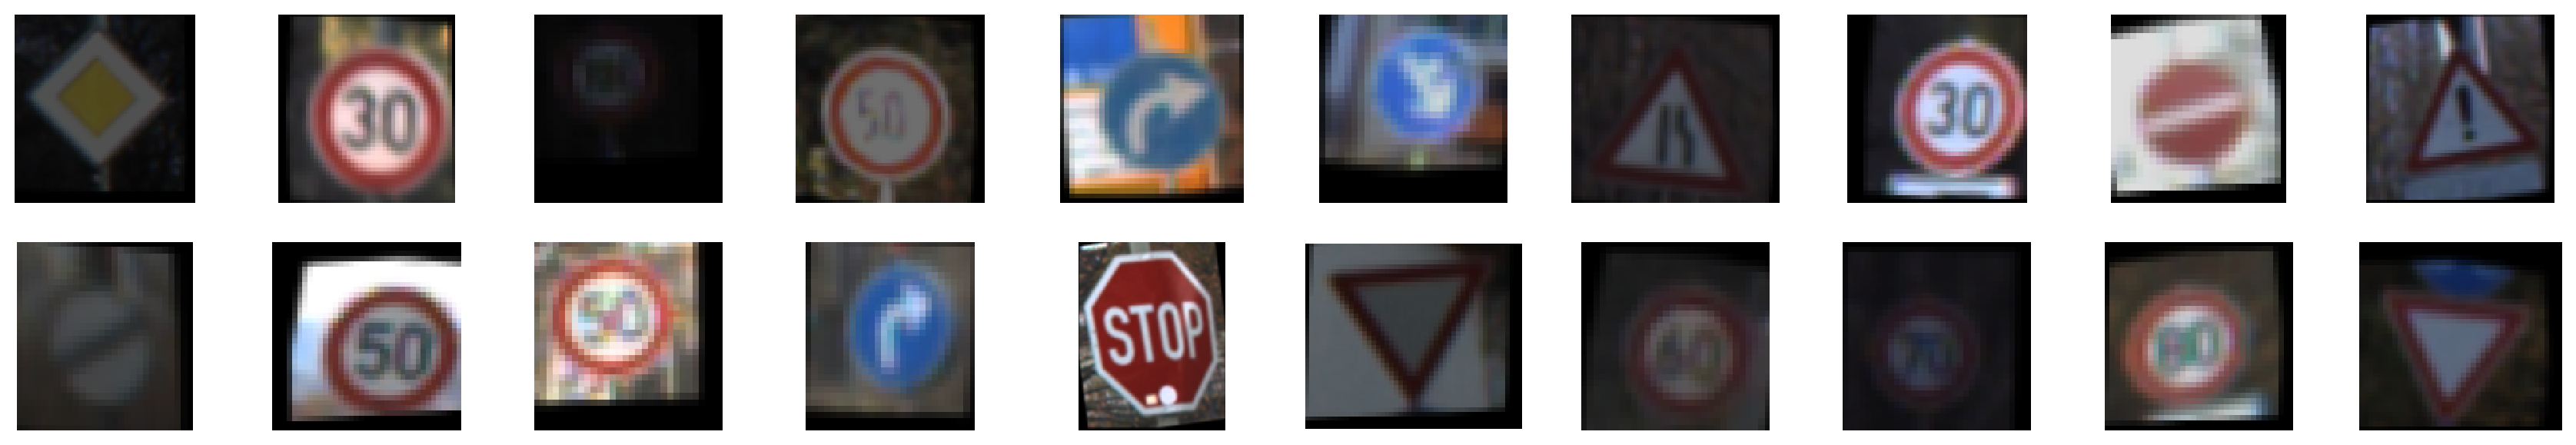

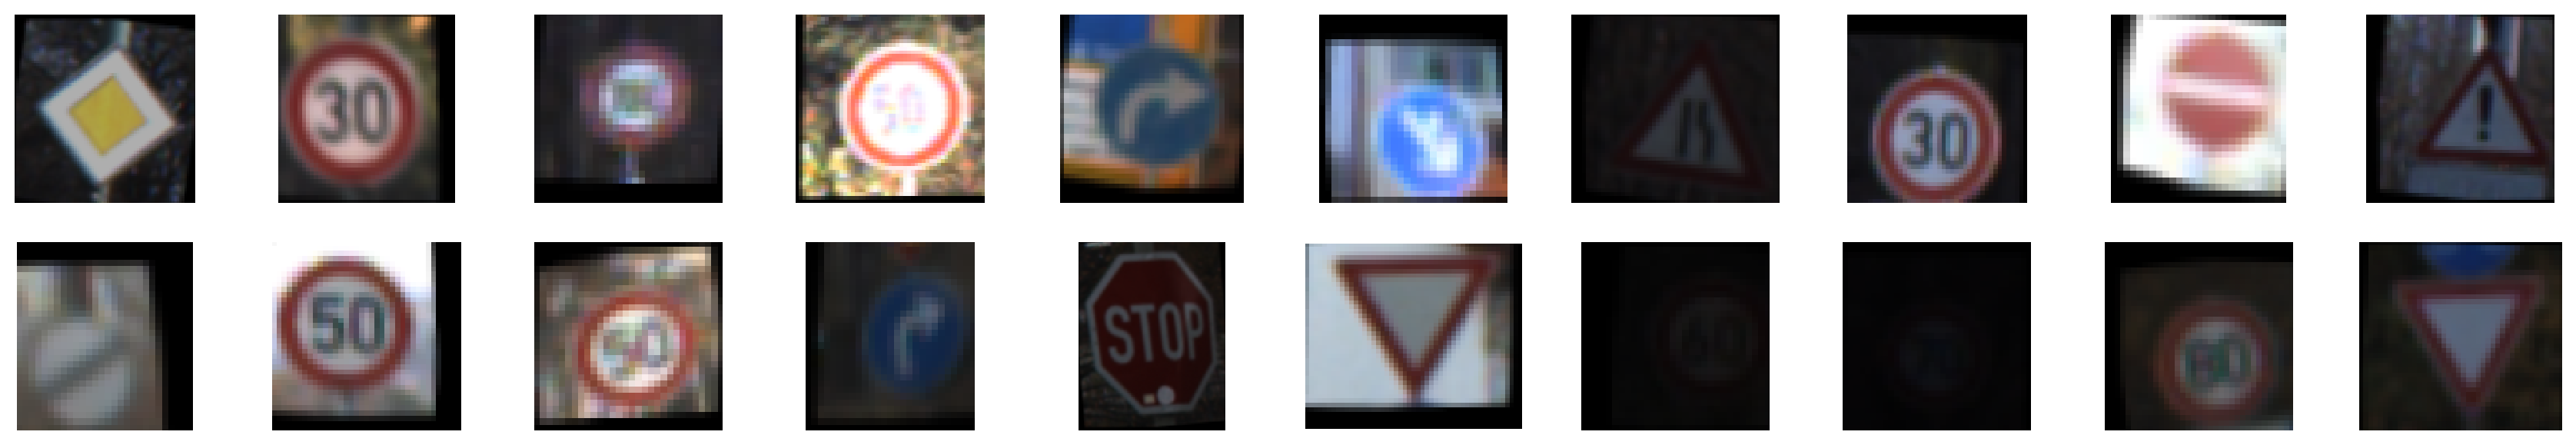

In [53]:
augmenter = lambda x: augment_image(x, brightness=0.7, angle=10, translation=5, shear=2)
sample_data = get_samples(traindf,20)
show_images(sample_data[10:], cols=10) #original images
for _ in range(5):
    show_images(sample_data, cols=10, func=augmenter)
    

In [ ]:
with Session() as session:
    functions = [loader, augmenter]
    pipeline = build_pipeline(functions, session, make_net(), make_adam(1.0e-3))
    train_eval(pipeline)

Epoch: 0 Train Score: 0.193 Evaluation Score: 0.190
Epoch: 1 Train Score: 0.209 Evaluation Score: 0.213
Epoch: 2 Train Score: 0.326 Evaluation Score: 0.329
Epoch: 3 Train Score: 0.484 Evaluation Score: 0.489
Epoch: 4 Train Score: 0.533 Evaluation Score: 0.528


**Conclusion**:

The hyper-parameters like brightness, rotation, translation, shear are tuned by looking at the randomly altered images.  If the alteration is too big, it is not so realistic.  The same way that horizontal flip is not included, a big change like rotating 90 degree should not be used.

The performance with the augmentation is much worse than without it.  There are two possible reasons:

1. the network is not robust to these changes (it was memorizing than generalizing)
2. it takes more time to train with larger data

Let's see how other preprocessing techniques can improve the performance first. Once that's done, we will use much bigger epochs to properly measure the performance.

## Data Normalization

In this section we will evaluate various normalization techniques to see which one has the best performance.

In [ ]:
normalizers = [('x - 127.5', lambda x: x - 127.5),
               ('x/127.5 - 0.5', lambda x: x/127.5 - 1.0),
               ('x/255/0 - 0.5', lambda x: x/255.0 - 0.5),
               ('x - x.mean()', lambda x: x - x.mean()),
               ('(x - x.mean())/x.std()', lambda x: (x - x.mean())/x.std())]

for name, normalizer in normalizers:
    print('Normalizer: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, normalizer]
        pipeline = build_pipeline(functions, session, make_net(), make_adam(1.0e-3))
        train_eval(pipeline)

Normalizer: x - 127.5
Epoch: 0 Train Score: 0.363 Evaluation Score: 0.356
Epoch: 1 Train Score: 0.509 Evaluation Score: 0.515
Epoch: 2 Train Score: 0.629 Evaluation Score: 0.621


**Conclusion**:

The performance with any of the normalizations is better than without them.  In this experiment, the normalization with `(x-x.mean())/x.std()` produced the best performance. 

In [ ]:
normilizer = lambda x: (x - x.mean()) / x.std()

## Color Space

Now, let us try difference color space to see if there is any performance gain.

Note: Gray scale has only one channel so it needs to be handled separately.

**Color Code Reference**:

- http://docs.opencv.org/3.2.0/de/d25/imgproc_color_conversions.html
- https://en.wikipedia.org/wiki/CIE_1931_color_space

In [ ]:
# for Gray scale, we need to add the 3rd dimension back (1 channel) as it's expected by the network
converters = [('Gray', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)[:, :, np.newaxis]),
              ('HSV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HSV)),
              ('HLS', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2HLS)),
              ('Lab', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Lab)),
              ('Luv', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2Luv)),
              ('XYZ', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2XYZ)),
              ('Yrb', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)),
              ('YUV', lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))]

GRAY_INPUT_SHAPE = (*INPUT_SHAPE[:2], 1)

for name, converter in converters:
    print('Color Space: {}'.format(name))
    with Session() as session:
        functions = [loader, augmenter, converter, normalizer]
        if name == 'Gray':
            network = make_net(input_shape=GRAY_INPUT_SHAPE) # there is only one channel in gray scale
        else:
            network = make_net()
        pipeline = build_pipeline(functions, session, network, make_adam(1.0e-3))
        train_eval(pipeline)
    print()

**Conlcusion**:

RGB (no conversion) is the best. 
I was expecting the gray scale to be more efficient as the traffic signs are mostly about shapes not colors.  
The gray scale would have reduced the dimensionality from 3 color channels to 1, which would make the learning faster/easier. 
Apparently, that is not the case.  


For preprocessing, we choose the normalizer as it is more effecient

In [ ]:
preprocessors = [loader, augmenter, normalizer]

# Model Improvement

Lets see if we can improve performance without overfitting by trying the following:

- add more layers in conv layers
- add more neurons in dense layers
- add more conv layers
- add more dense layers
- try different activation like elu instead of relu
- add dropout

In [ ]:
#Lets use some helper functions for plotting
def show_learning_curve(learning_curve):
    """
        Plots learning curve
    """
    epochs, train, valid = learning_curve
    plt.figure(figsize=(10,10))
    plt.plot(epochs, train, label='train')
    plt.plot(epochs, valid, label='validation')
    plt.title('Learning curve')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.xticks(epochs)
    plt.legend(loc='center right')
    
def show_confusion_matrix(cm):
    """
        Plots the confusion matrix
    """
    cm = [row/sum(row) for row in cm]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Oranges)
    fig.colorbar(cax)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class IDs')
    plt.ylabel('True Class IDs')
    plt.show()
    
def print_confusion_matrix(cm, sign_names=SIGN_NAMES):
    """
        Prints the confusion matrix
    """ 
    results = [(i, SIGN_NAMES[i], row[i]/sum(row)*100) for i, row in enumerate(cm)]
    accuracies = []
    for result in sorted(results, key=lambda x: -x[2]):
        print('{:>2} {:<50} {:6.2f}% {:>4}'.format(*result, sum(y_train==result[0])))
        accuracies.append(result[2])
    print('-'*50)
    print('Accuracy: Mean: {:.3f} Std: {:.3f}'.format(np.mean(accuracies), np.std(accuracies)))
    

Now, let us double the convulutional layers and neurons in the dense layers

In [ ]:
def make_net_double(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,12]) #previous 5,5,6
           .max_pool().relu()
           .conv([5,5,32]) #previous 5,5,16
           .max_pool()
           .relu().flatten().dense(240).relu().dense(N_CLASSES) #previous 120
           )

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline)
    session.save('checkpoint/make_net_double.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double())
    session.load('checkpoint/make_net_double.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The performance improved. The training accuracy is slightly higher than the validation accuracy.  It might be a sign of overfitting but I'll need to see by increasing the complexity of the network.

Let us try to doubling all filters in the convulutional layers and neurons in the dense layers

In [ ]:
def make_net_double2x(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,24]) #previous 5,5,12
           .max_pool().relu()
           .conv([5,5,64]) #previous 5,5,32
           .max_pool()
           .relu().flatten().dense(480).relu().dense(N_CLASSES) #previous 240
           )

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline)
    session.save('checkpoint/make_net_double2x.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x())
    session.load('checkpoint/make_net_double2x.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The performance is better.  It may be showing a slight overfitting.  Maybe it is not a good ideia to apply any regularization at this stage.  Let us rather try more epochs to see how far it can improve.

For almost all classes, the network is producing better than 90% accuracy, proving that increasing the network complexity is making it more robust.

Let us use make_net_double2x with more epochs

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline, epochs=20)
    session.save('checkpoint/make_net_double2x-20.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x())
    session.load('checkpoint/make_net_double2x-20.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The performance did improve but not in the last several epochs.  

100% accuracy is achieved for more classes.  Also, the bottom performer is improving as well.

Let's try a lower learning rate with epochs=20.

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(0.5e-3))
    learning_curve = train_eval(pipeline, epochs=20)
    session.save('checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x())
    session.load('checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The performance is almost the same  or slightly better.  The learning curve looks much smoother.  The average accuracy per class is slightly better, too.  Overall, smaller learning rate was a worthy change.

Decrease learning rate of make_net_double2x 

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(1.0e-4))
    learning_curve = train_eval(pipeline, epochs=20)
    session.save('checkpoint/make_net_double2x-20_lr_1.0e-4.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x())
    session.load('checkpoint/make_net_double2x-20_lr_1.0e-4.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

- The performance is worse and it seems to show some overfitting in the end.  
- The learning curve is much more smoother.
- The mean accuracy per class is worse and its standard devaition is bigger.

Let's stick with the previous learning rate for the time being.

Now let's try a leaky ReLU.

In [ ]:
def make_net_double2x_leakyrelu(input_shape=INPUT_SHAPE):
    """
    leak_ratio=0.01 Leaky ReLU
    """
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,24]) 
           .max_pool().relu(leak_ratio=0.01)
           .conv([5,5,64]) 
           .max_pool()
           .relu(leak_ratio=0.01).flatten().dense(480)
           .relu(leak_ratio=0.01).dense(N_CLASSES) 
           )


with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_leakyrelu(), make_adam(0.5e-3))
    learning_curve = train_eval(pipeline, epochs=20)
    session.save('checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_leakyrelu())
    session.load('checkpoint/make_net_double2x-20_lr_0.5e-3.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

No improvment.

It is time to try ELU (Exponential Linear Unit) activation which is supposed to be faster to learn than ReLU.

Reference: http://www.picalike.com/blog/2015/11/28/relu-was-yesterday-tomorrow-comes-elu/

In [ ]:
def make_net_double2x_elu(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,24]) 
           .max_pool().elu()
           .conv([5,5,64]) 
           .max_pool()
           .elu().flatten().dense(480).elu().dense(N_CLASSES) 
           )

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_elu(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline)
    session.save('checkpoint/make_net_double2x.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_elu())
    session.load('checkpoint/make_net_double2x.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The permance is worse.  Also, it did not learn faster.

Now let's try to set lower initial weight value

In [ ]:
def make_net_double2x_W(input_shape=INPUT_SHAPE):
    return (NeuralNetwork(weight_sigma=0.01) #smaller weight
           .input(input_shape)
           .conv([5,5,24]) 
           .max_pool().relu()
           .conv([5,5,64]) 
           .max_pool()
           .relu().flatten().dense(480).relu().dense(N_CLASSES) 
           )

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_W(), make_adam(1.0e-3))
    learning_curve = train_eval(pipeline)
    session.save('checkpoint/make_net_double2x_W.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_W())
    session.load('checkpoint/make_net_double2x_W.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

No improvement - a bit worse.

Poof, Let's try more epochs with a smaller learning rate.

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x(), make_adam(1.0e-4)) 
    learning_curve = train_eval(pipeline, epochs=80)
    
show_learning_curve(learning_curve)

**Conclusion**:

The performance has improved.  It appears that 80 epochs are good enough to achieve great performance.  

Is this as good as it can get?

Now let's try with a dropout

In [ ]:
def make_net_double2x_dropout(input_shape=INPUT_SHAPE):
    return (NeuralNetwork()
           .input(input_shape)
           .conv([5,5,24]) 
           .max_pool().relu().dropout(keep_prob=0.5)
           .conv([5,5,64]) 
           .max_pool()
           .relu().flatten().dense(480).relu().dense(N_CLASSES) 
           )


with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_dropout(), make_adam(1.0e-4)) 
    learning_curve = train_eval(pipeline, epochs=80)
    session.save('checkpoint/make_net_double2x_dropout.ckpt')
    
show_learning_curve(learning_curve)

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_dropout())
    session.load('checkpoint/make_net_double2x_dropout.ckpt')
    pred = pipeline.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
show_confusion_matrix(cm)
print_confusion_matrix(cm)

**Conclusion**:

The validation performance is more stable now.

## Test Dataset

In [ ]:
TEST_IMAGE_DIR = 'data/Final_Test/Images'

testdf  = pd.read_csv(os.path.join(TEST_IMAGE_DIR, 'GT-final_test.csv'), sep=';')
testdf['Filename'] = testdf['Filename'].apply(lambda x: os.path.join(TEST_IMAGE_DIR, x))
testdf.head()

In [ ]:
print("Number of test images: {:>5}".format(testdf.shape[0]))

In [7]:
X_test = testdf['Filename'].values
y_test = testdf['ClassId'].values

NameError: name 'testdf' is not defined

In [ ]:
with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_dropout())
    session.load('checkpoint/network_double2x_dropout.ckpt')
    score = pipeline.score(X_test, y_test)
    print('Test Score: {}'.format(score))

**Conclusion**:

It's about 96% accuracy.  For the simple network like this one, it did a really good work.


# Testing with Random Images


In [8]:
X_new = np.array(glob.glob('images/sign*.jpg') + 
                 glob.glob('images/sign*.png'))

In [9]:
new_images = [plt.imread(path) for path in X_new]

In [10]:
print('-' * 80)
print('New Images for Random Testing')
print('-' * 80)

plt.figure(figsize=(15,5))
for i, image in enumerate(new_images):
    plt.subplot(2,len(X_new)//2,i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])    
plt.show()

--------------------------------------------------------------------------------
New Images for Random Testing
--------------------------------------------------------------------------------


In [ ]:
print('getting top 5 results')

with Session() as session:
    pipeline = build_pipeline(preprocessors, session, make_net_double2x_dropout())
    session.load('checkpoint/make_net_double2x_dropout.ckpt')  
    prob = pipeline.predict_proba(X_new)
    estimator = pipeline.steps[-1][1]
    top_5_prob, top_5_pred = estimator.top_k_

print('done')

In [ ]:
print('-' * 80)
print('Top 5 Predictions')
print('-' * 80)

for i, (preds, probs, image) in enumerate(zip(top_5_pred, top_5_prob, new_images)):
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    for pred, prob in zip(preds.astype(int), probs):
        sign_name = SIGN_NAMES[pred]
        print('{:>5}: {:<50} ({:>14.10f}%)'.format(pred, sign_name, prob*100.0))
    print('-' * 80)    